In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier

We download the minst dataset and load to the X(features) and y(label).

In [3]:
minst_data_set = pd.read_csv('mnist_784.csv')
X = minst_data_set.drop(columns=['class'])
y = minst_data_set['class']


In [4]:
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


In [5]:
X = minst_data_set.drop(columns=['class'])
X = X.to_numpy()
y = minst_data_set['class']
y = y.to_numpy()

We convert labels from strings to 64-bit integers

In [6]:
y = y.astype(np.int64)
#X = X.astype(np.int64)
X, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int64))

We split the dataset using stratisfied splitting with a fixed random state = 42(assignment requirement)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state =42)

We retain only the first 10,000 entries from the training set and the first 2,000 from the test set

In [8]:
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:2000]
y_test = y_test[:2000]

In [9]:
# Print shapes to confirm the splits
print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training set shape: (10000, 784), Labels shape: (10000,)
Test set shape: (2000, 784), Labels shape: (2000,)


We perform a Grid Search with 5-fold cross validation, maximum features taking the values [100, 150,200], 
and the maximum depth the values [2, 4, 5], for a Decision Tree Classifier, using the Entropy criterion
and fixed random state(=42)

We will build a Pipeline to handle this problem using a scaler and the DesicionTreeClassifier.

In [10]:
dtree_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('dtree', DecisionTreeClassifier(criterion= 'entropy', random_state= 42))
    ])

We define the grid parameters that will be tested.

In [11]:
param_grid = [{'dtree__max_depth' : [2,4,5],
               'dtree__max_features' : [100, 150, 200]
               }]

We perform a Grid Search with 5-fold cross validation, with maximum features taking the values [100, 150,
200], and the maximum depth the values [2, 4, 5], for a Decision Tree Classifier, using the Entropy criterion
and fixed random state.

First we introduce the GridSearchCV.

In [12]:
grid_search = GridSearchCV(dtree_clf, param_grid, cv = 5, scoring= 'accuracy')

We fit GridSearch on the training data.

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dtree',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=42))]),
             param_grid=[{'dtree__max_depth': [2, 4, 5],
                          'dtree__max_features': [100, 150, 200]}],
             scoring='accuracy')

And we print the best parameters cross validation.

In [14]:
print('The best parameters of the model are: ', grid_search.best_params_)

The best parameters of the model are:  {'dtree__max_depth': 5, 'dtree__max_features': 150}


In [15]:
pd.set_option('max_colwidth', None) #We alter the DataFrame's way to display the full column width

We turn 'grid_searc.cv_results_' to a Pandas DataFrame for better manipulation of the data and we sort the results of the mean test by descending order.

In [16]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)

We display the results of all parameters combinations

In [17]:
comb_results = cv_results[['params', 'mean_test_score']]
comb_results

,params,mean_test_score
7,"{'dtree__max_depth': 5, 'dtree__max_features': 150}",0.6604
8,"{'dtree__max_depth': 5, 'dtree__max_features': 200}",0.6545
6,"{'dtree__max_depth': 5, 'dtree__max_features': 100}",0.6505
5,"{'dtree__max_depth': 4, 'dtree__max_features': 200}",0.5839
4,"{'dtree__max_depth': 4, 'dtree__max_features': 150}",0.5775
3,"{'dtree__max_depth': 4, 'dtree__max_features': 100}",0.5627
2,"{'dtree__max_depth': 2, 'dtree__max_features': 200}",0.3230
1,"{'dtree__max_depth': 2, 'dtree__max_features': 150}",0.3162
0,"{'dtree__max_depth': 2, 'dtree__max_features': 100}",0.3162


In [18]:
best_GS_accuracy = round(comb_results['mean_test_score'].max(),5);print(best_GS_accuracy)

0.6604


We create and train a model using the best parameters we found with GridSearchCV. We will do it through a pipeline.

In [19]:
dtree_clf_best = Pipeline([
    ('scaler', StandardScaler()),
    ('dtree', DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, max_features= 150, random_state= 42))
    ])

In [20]:
dtree_clf_best.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dtree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        max_features=150, random_state=42))])

We calculate the model's predictions using the test's target values

In [21]:
y_pred = dtree_clf_best.predict(X_test)

And we calculate the f1_score (with average set to macro) and the accuracy_score.

In [22]:
f1_score_macro = round(f1_score(y_test, y_pred, average= 'macro'),4)
accuracy = round(accuracy_score(y_test, y_pred),4)

Finally we print the metrics results

In [23]:
print(f'The f1_score metric of the model with best parameters is: {f1_score_macro}')
print(f'The accuaracy score metric of the model with best parameters is: {accuracy}')
print(f'The accuracy score metric of the GridSearch is: {best_GS_accuracy} ')

The f1_score metric of the model with best parameters is: 0.6645
The accuaracy score metric of the model with best parameters is: 0.6765
The accuracy score metric of the GridSearch is: 0.6604 


Since the model performance on the test set is better, we can safely assume that is generalizing well. But the scores are moderate meaning that it's not good enough(at least for critical and precise demanding decisions).

We will create a pipeline performing PCA with fixed random state, retaining 90% of the variance of the
initial features included in training dataset, to reduce dimensionality of the dataset.

In [24]:
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca_95', PCA(n_components= 0.90, random_state= 42)),
    ('dtree', DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, random_state= 42))
    ])

We fit the training data to the pca_pipeline

In [25]:
pca_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca_95', PCA(n_components=0.9, random_state=42)),
                ('dtree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])

We calculate the predictions of the target variable using the model:

In [26]:
y_pred_pca = pca_pipeline.predict(X_test)

And finally we compute the accuracy and f1 metrics of the model with respect to the test data.

In [27]:
accuracy_pca = round(accuracy_score(y_test, y_pred_pca),4)
f1_macro_pca = round(f1_score(y_test, y_pred_pca, average= 'macro'),4)
print(f'The accuracy score after performing pca is: {accuracy_pca}')
print(f'The f1_macro score after performing pca is: {f1_macro_pca}')

The accuracy score after performing pca is: 0.672
The f1_macro score after performing pca is: 0.6682


Comparing the results of the two metrics for the two models, we observe that PCA slightly reduces accuracy, but it improves the F1-macro score. The small drop in accuracy indicates that PCA might have lost some information(10% in our case) that could have helped the model make precise predictions. However, the improvement in F1-macro shows that PCA likely reduced noise or irrelevant features, allowing the model to generalize better across all classes

We will perform PCA with the number of components dictated in the previous question, compress the training data and train a Gradient Boosting Classifier (GBC). The model should have a maximum depth of 2, 6 estimators and a learning rate equal to 1.0. 

In [28]:
gbc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca_95', PCA(n_components= 0.90, random_state= 42)),
    ('gbc', GradientBoostingClassifier(max_depth= 2, n_estimators= 6, learning_rate= 1.0, random_state= 42))
])

We fit and train the model using the pipeline we constructed.

In [29]:
gbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca_95', PCA(n_components=0.9, random_state=42)),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            n_estimators=6, random_state=42))])

We use the pipeline to predict labels using the X_test data.

In [30]:
y_pred_pca_gbc = gbc_pipeline.predict(X_test)

And finally we compute the two metrics accuracy and f1_macro for the model predictions.

In [31]:
accuracy_pca_gbc = round(accuracy_score(y_test, y_pred_pca_gbc),4);accuracy_pca_gbc
f1_macro_pca_gbc = round(f1_score(y_test, y_pred_pca_gbc, average= 'macro'),4); f1_macro_pca_gbc
print(f'The accuracy score after performing pca and using GBC is: {accuracy_pca_gbc}')
print(f'The f1_macro score after performing pca and using GBC is: {f1_macro_pca_gbc}')

The accuracy score after performing pca and using GBC is: 0.794
The f1_macro score after performing pca and using GBC is: 0.7903


The performance of the GBC model, in both metrics is now higher. This comes mostly from the fact that GBC builds an ensemble of shallow trees (weak learners, max_depth=2), where each tree incrementally corrects the errors of the previous ones. This iterative improvement leads to a model that generalizes better by combining the strengths of many weak learners. On the other hand a deeper tree (max_depth=5) has more splits and can easily memorize patterns in the training data, leading to high variance and poor generalization to unseen data.

We will reconstruct the first five images (digits) by using the output of PCA we evaluated previously, and will plot them along with their corresponding originals in the same figure.

We set the same parameter for pca(n_components= 0.90)

In [32]:
pca_reduce_pipeline = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components= 0.90,random_state=42))
])

We aplly pca to the training data to get the reduced X_train

In [33]:
X_train_reduced = pca_reduce_pipeline.fit_transform(X_train)
X_train_recovered = pca_reduce_pipeline.inverse_transform(X_train_reduced)

We difine the function that will reshape and plot the image data

In [34]:
def plot_digit(image_data):
 image = image_data.reshape(28, 28)
 plt.imshow(image, cmap="binary")
 plt.axis("off")

In [35]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=28)
plt.rc('axes', labelsize=14, titlesize=30)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=10)
plt.tight_layout(rect=[5, 5, 1, 0.95])

<Figure size 640x480 with 0 Axes>

We plot the first five reduced training instances along with the originals.

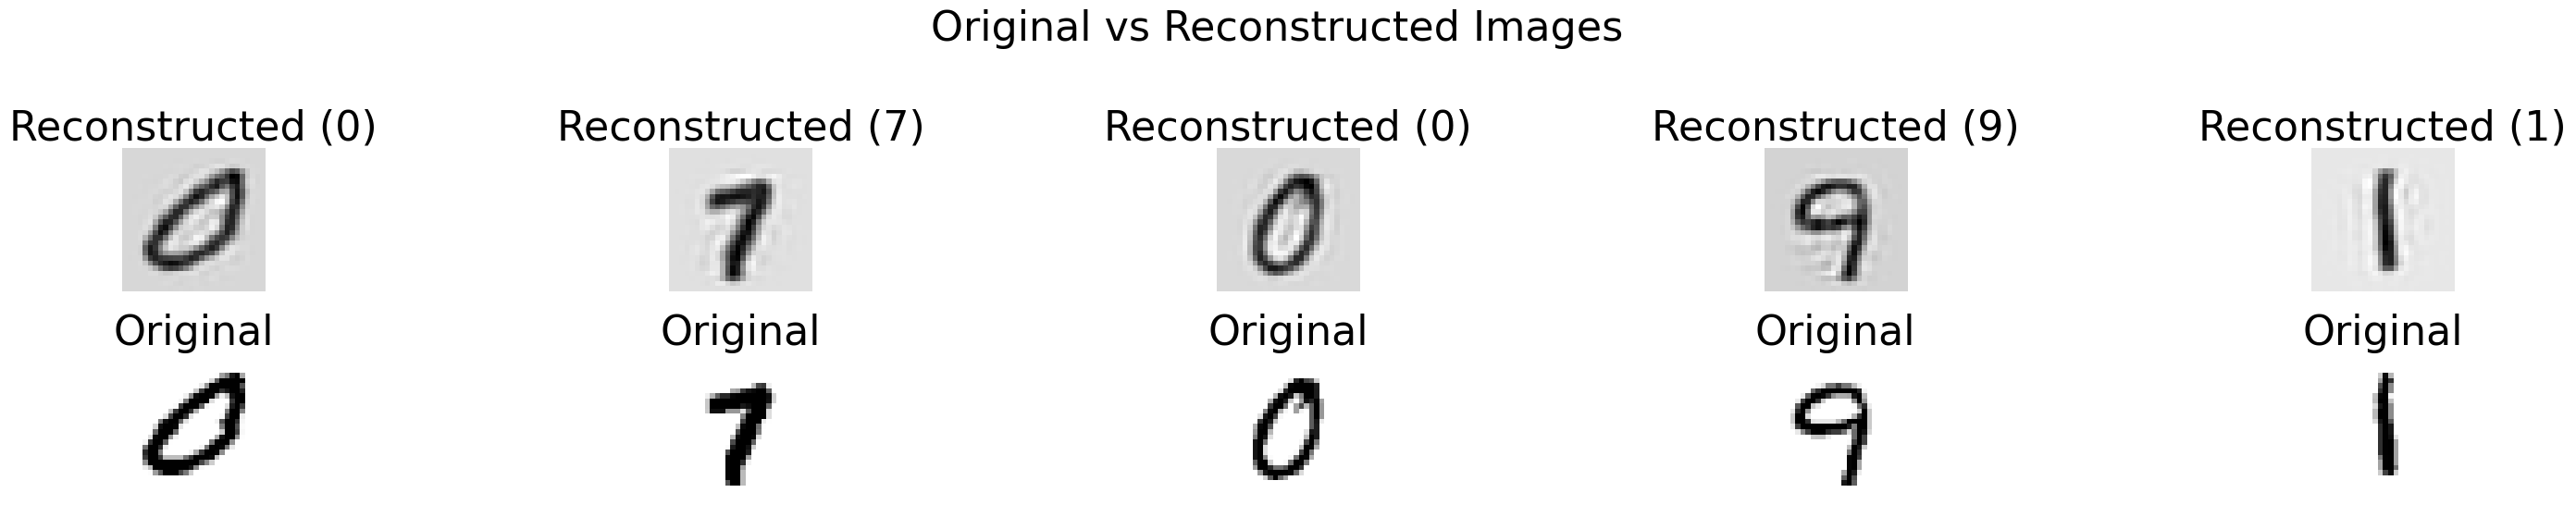

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(30, 6))
fig.suptitle("Original vs Reconstructed Images", fontsize=32)
plt.tight_layout(rect=[0, 0, 1, 0.95])

for i in range(5):
    plt.subplot(2, 5, i+1)
    plot_digit(X_train_recovered[i])
    plt.title(f"Reconstructed ({y_train[i]})", fontsize=32)
    plt.subplot(2, 5, i + 6)
    plot_digit(X_train[i])
    plt.title(f"Original", fontsize=32)
    

We see that we have lost some information of the pictures displayed but the images are still mostly intact. 

We will perform KMeans Clustering, with 20 clusters, using the PCA transformed training data and plot the most representative digits in a Figure with 2 rows and 10 columns. The most representative digit of each cluster is the one that is closer to its corresponding centroid.

We define the number of clusters and the kmeans algorithm

In [37]:
k = 20 
k_means = KMeans(n_clusters= k, random_state= 42) 

For each cluster, we’ll find the image closest to the centroid. First we fit the reduced data to KMeans and we measure the distance of its distance the centroid clusters(X_digits_dist). We extract the indexes of the minimum distances to its cluster(representative_digits_idx) and apply this mask to the X_train dataset to retrieve the digits they refer to.

In [38]:
X_digits_dist = k_means.fit_transform(X_train_reduced)
representative_digits_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digits_idx]
# X_digits_dist = k_means.fit_transform(X_train_recovered)
# representative_digits_idx = np.argmin(X_digits_dist, axis=0)
# X_representative_digits = X_train[representative_digits_idx]

We plot these (representative) points.

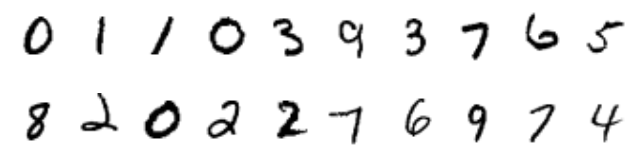

In [39]:
# extra code – this cell generates and saves Figure 9–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(28, 28), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

We will manually label the printed images of these representative points and store them in  vector y_representative_digits

In [40]:
y_representative_digits = np.array([0, 1, 1, 0, 3, 9, 3, 7, 6, 5, 8, 2, 0, 2, 2, 7, 6, 9, 7, 4])
#len(y_representative_digits)


In [41]:
print(y_train[representative_digits_idx])
print(y_representative_digits)

[0 1 1 0 3 9 3 7 6 5 8 2 0 2 2 7 6 9 7 4]
[0 1 1 0 3 9 3 7 6 5 8 2 0 2 2 7 6 9 7 4]


In [42]:
X_test_reduced = pca_reduce_pipeline.transform(X_test)

In [43]:
y_pred_kmeans = k_means.predict(X_test_reduced) #labels assigned to the test data

In [44]:
y_test_propagated = np.empty(len(X_test_reduced), dtype=np.int64)

In [45]:
for i in range(k):
 y_test_propagated[y_pred_kmeans == i] = y_representative_digits[i]

In [46]:
accuracy_pca_kmeans_representatives = accuracy_score(y_test,y_test_propagated)
f1_macro_pca_kmeans_representatives = round(f1_score(y_test,y_test_propagated, average= 'macro'),4)
print(f'The accuracy score after performing pca and using kmeans label propagation is: {accuracy_pca_kmeans_representatives}')
print(f'The f1_macro score after performing pca and using kmeans and label propagation is: {f1_macro_pca_kmeans_representatives}')

The accuracy score after performing pca and using kmeans label propagation is: 0.6645
The f1_macro score after performing pca and using kmeans and label propagation is: 0.6516


In [47]:
df = {'Model': ['DTree', 'DTree_with_PCA', 'GBC_with_PCA', 'Kmeans_with_PCA_reps'],
      'Accuracy_score': [accuracy, accuracy_pca, accuracy_pca_gbc, accuracy_pca_kmeans_representatives],
      'F1_macro_score': [f1_score_macro, f1_macro_pca, f1_macro_pca_gbc, f1_macro_pca_kmeans_representatives],
      'Times_sec': [35, 17, 158, 3]}

df = pd.DataFrame(df)
df = df.set_index('Model')

As we see on the table below, the delivered metrics are almost the same 'good' as the Desicion tree model and Decision tree model with pca applied(after GridSearch which is computationaly expensive) and only lucks in performance to the Gradient Boosting Classifier which again costs even more time wise.

In [48]:
print(df)

                      Accuracy_score  F1_macro_score  Times_sec
Model                                                          
DTree                         0.6765          0.6645         35
DTree_with_PCA                0.6720          0.6682         17
GBC_with_PCA                  0.7940          0.7903        158
Kmeans_with_PCA_reps          0.6645          0.6516          3
